# Banderazo por el mar - 10/03/2018
Vamos a probar de dibujar una bandera del mar, pero que en su parte superior siga el perfil de elevación de la ruta del banderazo (carretera El Alto / Apacheta - Oruro).

## Digitalización de la ruta
Primero, digitalizamos la ruta con QGis: colocamos un fondo de OpenStreetMap, creamos una nueva capa vectorial de tipo Shapefile, creamos un nuevo objeto Línea, digitalizando desde Apacheta (barrio a la salida de El Alto) hasta el Casco Minero en la entrada de la ciudad de Oruro, siguiendo la doble vía La Paz - Oruro.

![Digitalización de la ruta del banderazo en QGis](digitalizacion_qgis.png "Digitalización en QGis")

Exportamos el trazo en el archivo [ruta_banderazo.geojson](ruta_banderazo.geojson). Lo cargamos y visualizamos usando [geopandas](http://geopandas.org/):

In [1]:
import geopandas as gpd
ruta_banderazo = gpd.read_file('ruta_banderazo.geojson')
ruta_banderazo.plot()

La capa usa la proyección "pseudo-Mercator" / EPSG:3857. Para lo que sigue, la reproyectamos en WGS84 / EPSG:4326.

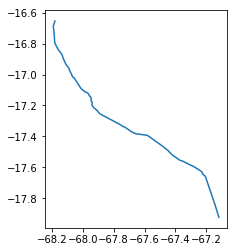

In [2]:
ruta_banderazo = ruta_banderazo.to_crs({'init': 'epsg:4326'})
ruta_banderazo.plot()

## Elevación

Ahora queremos calcular la elevación de la ruta, o sea para cada punto de la línea, encontrar la altura en metros, a partir de un archivo raster de elevación.

Lo más simple es llamar a un servicio que hará el cálculo. Para eso usamos la librería [geocoder](https://geocoder.readthedocs.io/providers/Google.html#elevation) y en particular el servicio de Google. Para que funcione, es necesario tener la variable `GOOGLE_API_KEY` establecida con el valor de la clave, en el entorno de bash.

Para saber como manipular los datos, en este caso LineString, ver la librería [shapely](https://shapely.readthedocs.io/en/latest/).

Hacemos la prueba del servicio de Google para encontrar la elevación del primer punto (Apacheta, salida de El Alto)

In [13]:
# sudo python3 -m pip install geocoder
import geocoder
# Hacemos la prueba con el primer punto, Apacheta
# Nota: hay que manipular un poco el orden y la forma de presentar latitud y longitud
punto1 = [ruta_banderazo.geometry[0].coords[0][1], ruta_banderazo.geometry[0].coords[0][0]]
g = geocoder.google(punto1, method='elevation')
print(f'El primer punto (Apacheta) se encuentra a {g.meters} msnm')

El primer punto (Apacheta) se encuentra a 3961.9 msnm


Es correcto, aproximadamente 4.000 metros sobre el nivel del mar.

## Distancia

Para poder generar el perfil de elevación, es necesario también calcular la distancia en kilometros entre dos puntos. Hay dos formas de hacer: proyectar en metros y calcular la distancia euclidiana, o calcular la distancia "geográfica" con cálculos sobre la esfera. Usaremos la segunda forma, gracias al algoritmo de Vincenty. Para eso tenemos que importar la librería [GeoPy](https://geopy.readthedocs.io/en/latest/index.html#module-geopy.distance).

Para hacer la prueba, calculamos la distancia entre los dos primeros puntos, que están dentro del mismo barrio.

In [16]:
# sudo python3 -m pip install geopy
from geopy.distance import vincenty
punto1 = ruta_banderazo.geometry[0].coords[0]
punto2 = ruta_banderazo.geometry[0].coords[1]
print(f'La distancia entre los dos primeros puntos es de {vincenty(punto1, punto2).m} metros')

La distancia entre los dos primeros puntos es de 335.5501109716255 metros


Perfecto, unos 300 metros entre los dos primeros puntos, es correcto.

## Perfil de elevación

Ahora, vamos a construir el perfil de elevación, poniendo en `x` la distancia en kilometros del punto desde el primer punto, y en `y` la altura en metros. Hay 144 puntos, las llamadas a la API de Google toman un cierto tiempo.

In [83]:
distancia = []
elevacion = []
punto_anterior = ruta_banderazo.geometry[0].coords[0]

for i in range(0, len(ruta_banderazo.geometry[0].coords)):
#for i in range(0, 20):
    punto = ruta_banderazo.geometry[0].coords[i]
    distancia.append(vincenty(punto_anterior, punto).km)
    
    # hay que probar varias veces, porque en mi caso, un 25% de las consultas falla
    pruebas = 0
    altura = None
    while altura is None and pruebas < 10:
        altura = geocoder.google([punto[1], punto[0]], method='elevation').meters
        pruebas += 1
    elevacion.append(altura)
    punto_anterior = punto

# Hay que sumar las distancias de manera cumulativa
import numpy as np
distancia_acumulada = np.cumsum(distancia)

Mostramos el perfil usando [matplotlib](https://matplotlib.org/)

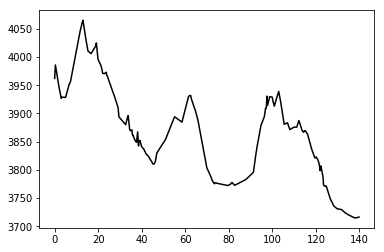

In [84]:
import matplotlib.pyplot as plt

ax1 = plt.subplot()
ax1.plot(distancia_acumulada, elevacion, 'k')

plt.show()

## Dibujo de la bandera

Primero vamos a dibujar solamente un rectángulo azul, con la parte superior que sigue el perfil de elevación. Y luego aplicaremos este rectángulo como [patch](https://matplotlib.org/api/_as_gen/matplotlib.patches.Polygon.html#matplotlib.patches.Polygon) sobre una imagen de la bandera maritima.

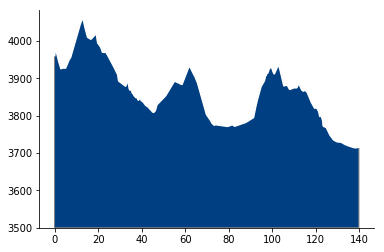

In [93]:
from matplotlib.patches import Polygon

elevacion_min = 3500

fig, ax = plt.subplots()
plt.plot(distancia_acumulada, elevacion, 'w', linewidth=2)
plt.ylim(ymin=elevacion_min)

# Make the shaded region
verts = [(0, elevacion_min)] + list(zip(distancia_acumulada, elevacion)) + [(distancia_acumulada[len(distancia_acumulada)-1], elevacion_min)]
poly = Polygon(verts, facecolor='#003f82', edgecolor='0.5')
ax.add_patch(poly)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

plt.show()

Ahora mostramos la imagen de la bandera, y le aplicamos el perfil.

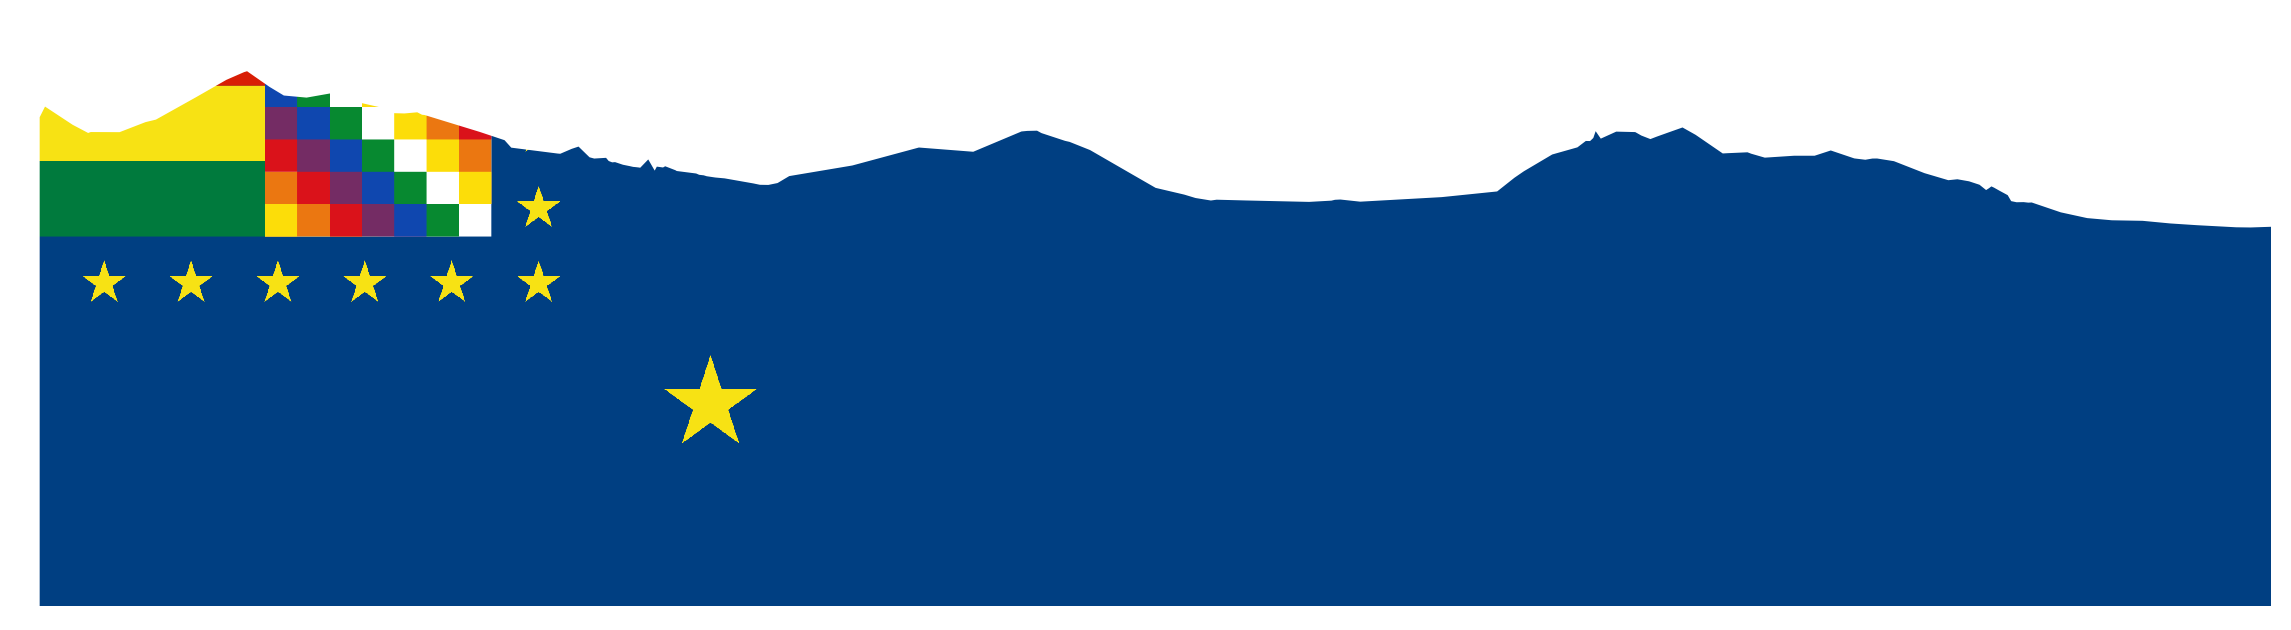

In [115]:
image = plt.imread('bandera.png')
px_alto, px_largo, z = image.shape

fig, ax = plt.subplots(figsize=(40, 20))
im = ax.imshow(image)

# Ponemos el pefil de elevación a la escala de la imagen
distancia_px = distancia_acumulada / max(distancia_acumulada) * px_largo
elevacion_px = [(4200 - x) for x in elevacion]
verts = [(0, px_alto)] + list(zip(distancia_px, elevacion_px)) + [(max(distancia_px), px_alto)]
poly = Polygon(verts, edgecolor='0.5', transform=ax.transData)

# Aplicamos la mascara sobre la imagen
im.set_clip_path(poly)
ax.axis('off')

plt.savefig('BanderazoPorElMar.png', bbox_inches='tight')